# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Оглавление

<a id='intro'></a>
[1. Загрузка и подготовка данных](#task1).

[2. Обучение и проверка модели](#task2).

[3. Подготовка к расчёту прибыли](#task3).

[4. Расчёт прибыли и рисков ](#task4).

[5. Общий вывод](#task5).

[6. Чек-лист готовности проекта](#task6).

# Цели исследования

- Построить модель для определения региона, где добыча принесёт наибольшую прибыль;
- Проанализировать возможную прибыль и риски техникой Bootstrap.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
 - `/datasets/geo_data_0.csv`
 - `/datasets/geo_data_1.csv`
 - `datasets/geo_data_2.csv`
 
1) *`id`* — уникальный идентификатор скважины;

2) *`f0, f1, f2`* — три признака точек (неважно, что они означают, но сами признаки значимы);

3) *`product`* — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# План работы

1. Изучить информацию о данных. Загрузить и подготовить данные.
2. Обучить и проверить модель для каждого региона.
3. Подготовиться к расчёту прибыли. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
5. Посчитать риски и прибыль для каждого региона.

[Оглавление](#intro).
<a id='task1'></a>

## Загрузка и подготовка данных

**Импортируем библиотеку pandas.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
!"{sys.executable}" -m pip install phik

import phik
from phik.report import plot_correlation_matrix
from phik import report

from numpy.random import RandomState
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

**Ключевые значения параметров для рассчета:**

In [2]:
# При разведке региона исследуют 500 точек
POINTS = 500 

# При разведке региона выбирают 200 лучших точек
BEST_POINTS = 200

# Бюджет на разработку скважин в регионе в млрд руб
BUDGET = 10_000_000_000

# Доход с каждой единицы продукта в рублях, 
# поскольку объём указан в тысячах баррелей
EARNINGS = 450_000 

# Вероятность убытков меньше 2.5%
LOSS_PROBABILITY = 0.025

**Считайем данные из csv-файла в датафрейм и сохраним в переменную `data`. Путь к файлу:**

`/datasets/geo_data_0.csv`

`/datasets/geo_data_1.csv`

`/datasets/geo_data_2.csv`

In [3]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except: 
    data_0 = 'ошибка при выгрузке данных!'
    data_1 = 'ошибка при выгрузке данных!'
    data_2 = 'ошибка при выгрузке данных!'

**Выведем первые 10 строк датафрейма `data_x` на экран.**

In [4]:
data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [5]:
data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [6]:
data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


**Выведем основную информацию о данном датафрейме с помощью метода info().**

In [7]:
data_0.info()
print('#'*40)
data_1.info()
print('#'*40)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

**Выведем информацию о количестве пропусков по столбцам в данных датафреймах с помощью метода isna().**

In [8]:
print('Количество пропусков в датасете data_0:\n', data_0.isna().sum())
print()
print('Количество пропусков в датасете data_1:\n',data_1.isna().sum())
print()
print('Количество пропусков в датасете data_2:\n',data_2.isna().sum())

Количество пропусков в датасете data_0:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество пропусков в датасете data_1:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество пропусков в датасете data_2:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков не обнаружено.

**Проверим, есть ли строки-дубликаты в датасетах `data_х`**

In [9]:
print('Количество дубликатов в датасете data_0:', data_0.duplicated().sum())
print('Количество дубликатов в датасете data_1:', data_1.duplicated().sum())
print('Количество дубликатов в датасете data_2:', data_2.duplicated().sum())

Количество дубликатов в датасете data_0: 0
Количество дубликатов в датасете data_1: 0
Количество дубликатов в датасете data_2: 0


Полных дубликатов не обнаружено.

Но проверим, вдруг одни и те же скважины были оценены по разному, поэтому они не проявлялись в поиске дубликатов по всему датасету.

In [10]:
print('Количество дубликатов в датасете data_0:', data_0['id'].duplicated().sum())
print('Количество дубликатов в датасете data_1:', data_1['id'].duplicated().sum())
print('Количество дубликатов в датасете data_2:', data_2['id'].duplicated().sum())

Количество дубликатов в датасете data_0: 10
Количество дубликатов в датасете data_1: 4
Количество дубликатов в датасете data_2: 4


Можно удалить данные дубликаты, так как их количество меньше 10%.

In [11]:
data_0 = data_0.drop_duplicates(['id'], keep='last')
data_1 = data_1.drop_duplicates(['id'], keep='last')
data_2 = data_2.drop_duplicates(['id'], keep='last')

**Проверим, есть ли подозрительные и выбивающиеся данные в датасетах `data_x`**

In [12]:
print('Количество дубликатов в датасете data_0:\n', data_0.describe())
print('Количество дубликатов в датасете data_1:\n', data_1.describe())
print('Количество дубликатов в датасете data_2:\n', data_2.describe())

Количество дубликатов в датасете data_0:
                  f0            f1            f2       product
count  99990.000000  99990.000000  99990.000000  99990.000000
mean       0.500412      0.250149      2.502656     92.499482
std        0.871867      0.504434      3.248155     44.289431
min       -1.408605     -0.848218    -12.088328      0.000000
25%       -0.072683     -0.200877      0.287887     56.496838
50%        0.502340      0.250252      2.516005     91.849972
75%        1.073626      0.700654      4.714970    128.564269
max        2.362331      1.343769     16.003790    185.364347
Количество дубликатов в датасете data_1:
                  f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       1.141450     -4.796493      2.494551     68.825232
std        8.965922      5.119900      1.703579     45.944649
min      -31.609576    -26.358598     -0.018144      0.000000
25%       -6.298525     -8.267985      1.000021 

По данным ничего нельзя сказать, так как не понятно, что это за признаки и какие значения для данных признаков являются нормальными. 

**Оценим распределение числовых признаков для датасета `data_0`.**

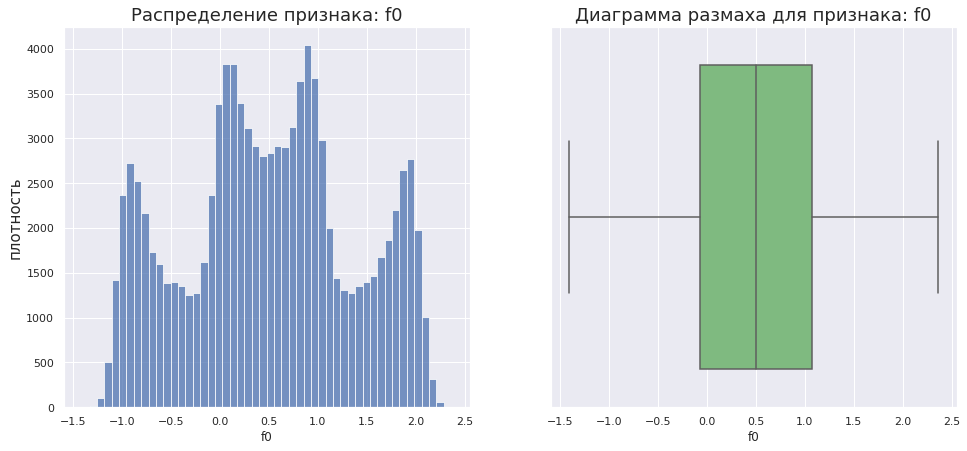

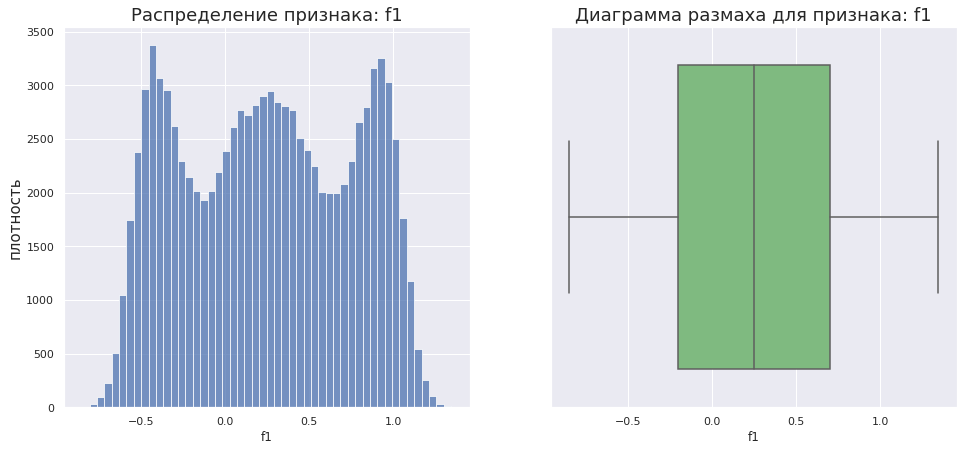

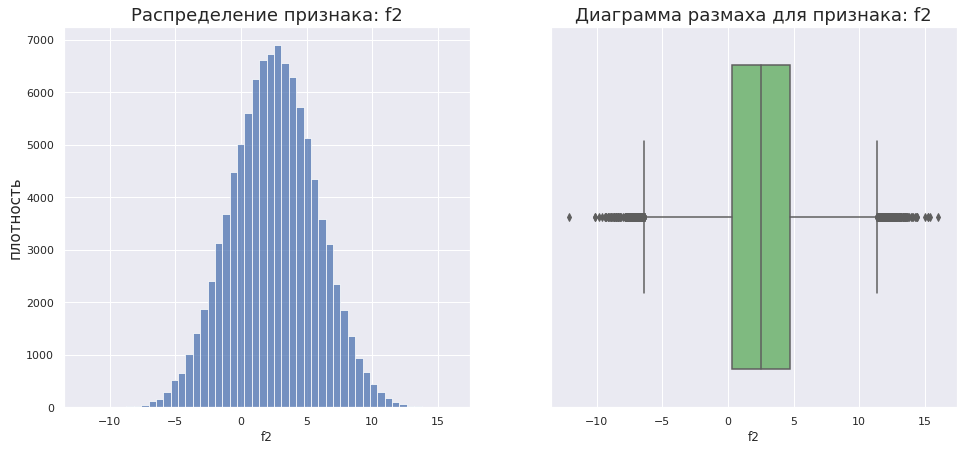

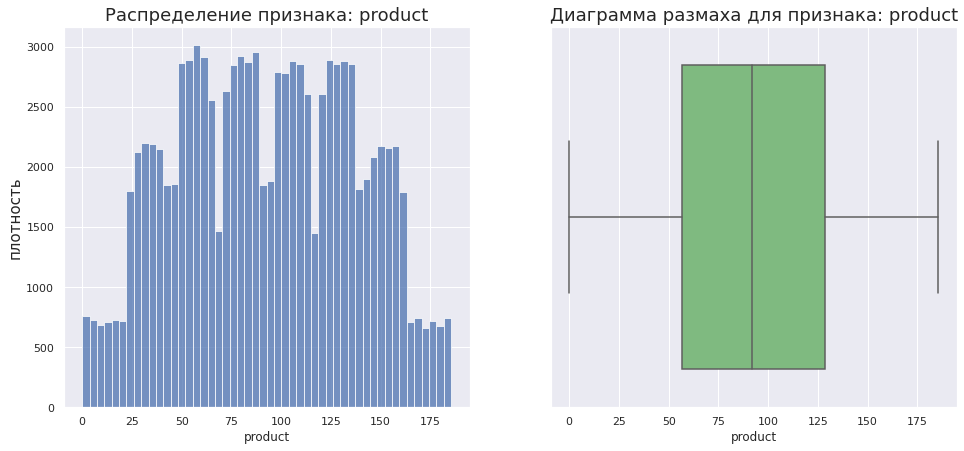

In [13]:
# функция для построения диаграммы размаха и гистограммы
def plot_hist(data, label, bins):
    
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 7));
    axes[0].set_title("Распределение признака: " + label, fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    
    sns.histplot(data, bins=bins, ax=axes[0]);
    sns.boxplot(x=data,
                     palette='Greens_r',
                     ax=axes[1]
                     );

    axes[1].set_title('Диаграмма размаха для признака: ' + label, size=18)
    plt.show();

num_features = [ 'f0', 'f1', 'f2', 'product']
for column in num_features:
    plot_hist(data_0[column], column, 50);

**Оценим распределение числовых признаков для датасета `data_1`.**

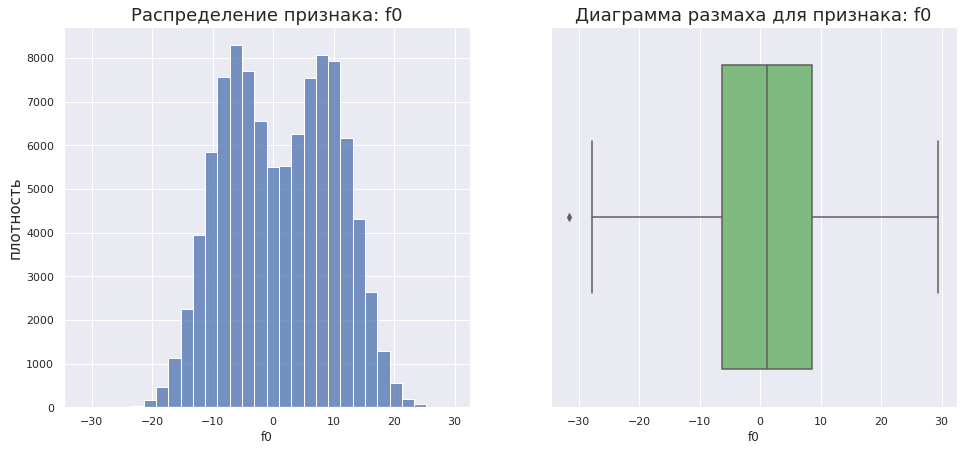

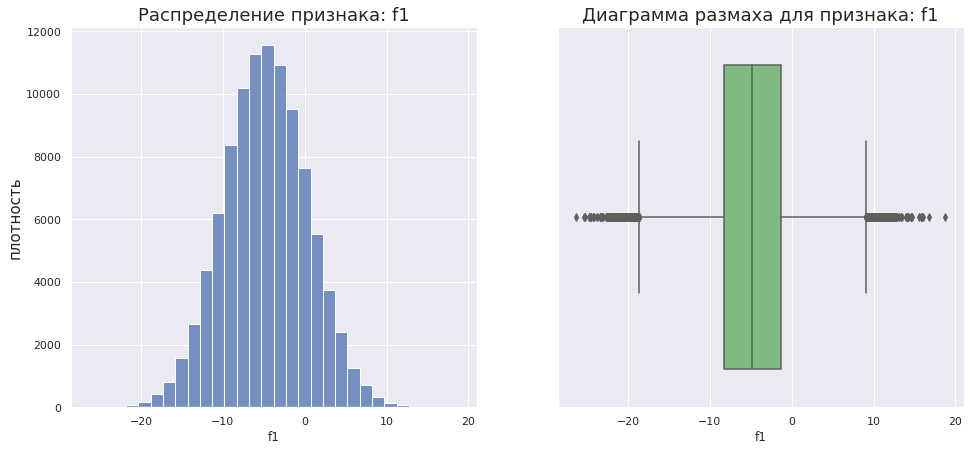

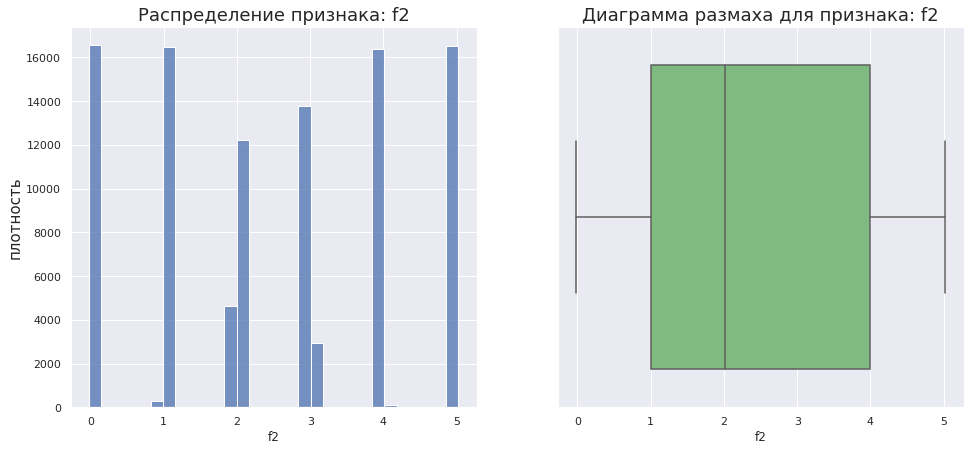

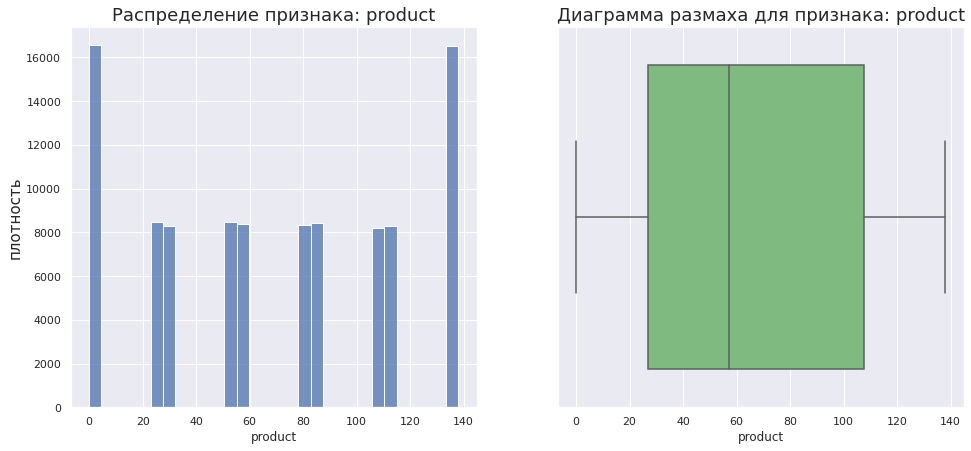

In [14]:
for column in num_features:
    plot_hist(data_1[column], column, 30);

In [15]:
data_1['f2'].unique()

array([-5.87601369e-03,  9.99182737e-01,  5.00116016e+00, ...,
        4.99865060e+00,  1.00014635e+00, -3.29851829e-03])

In [16]:
data_1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

Есть у признака и отрицательные значения. Но не понятно, куда это ведет, может быть нужно убрать отрицательные значения и ограничить датасет нулем. Но если бы мы лучше понимали что означает признак, может быть было бы проще понять. Нужно уточнить у коллег.

**Оценим распределение числовых признаков для датасета `data_2`.**

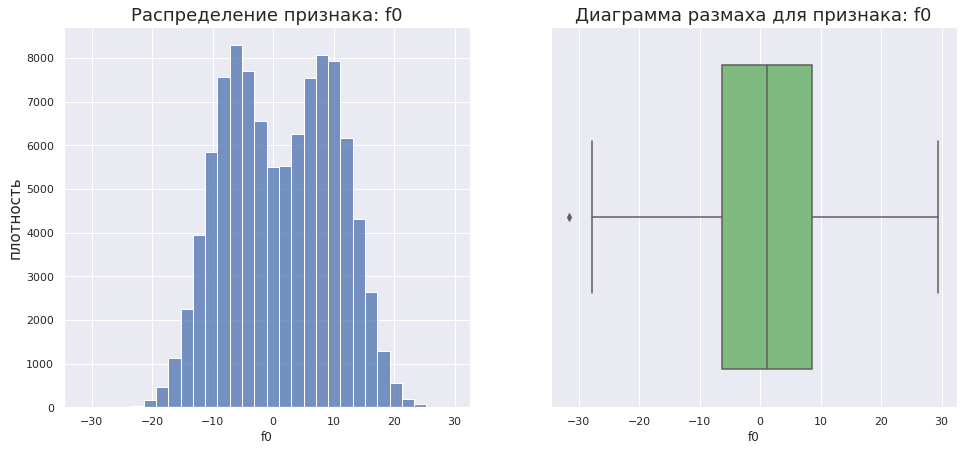

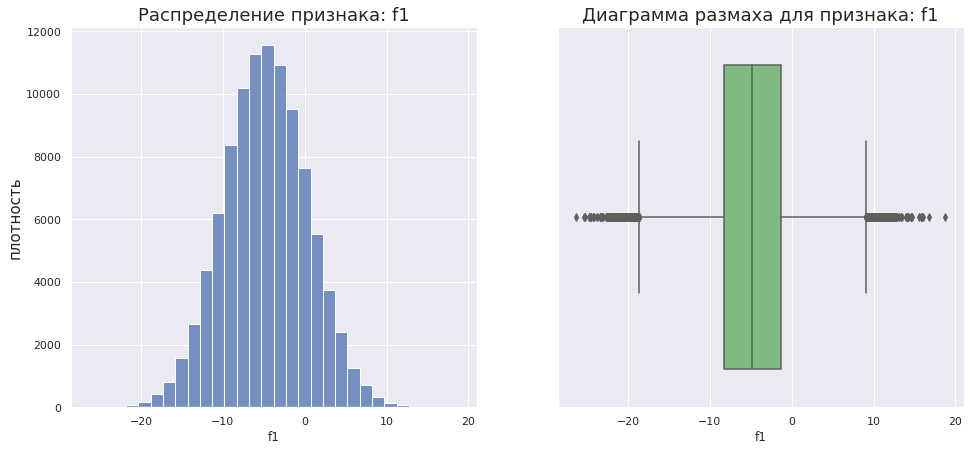

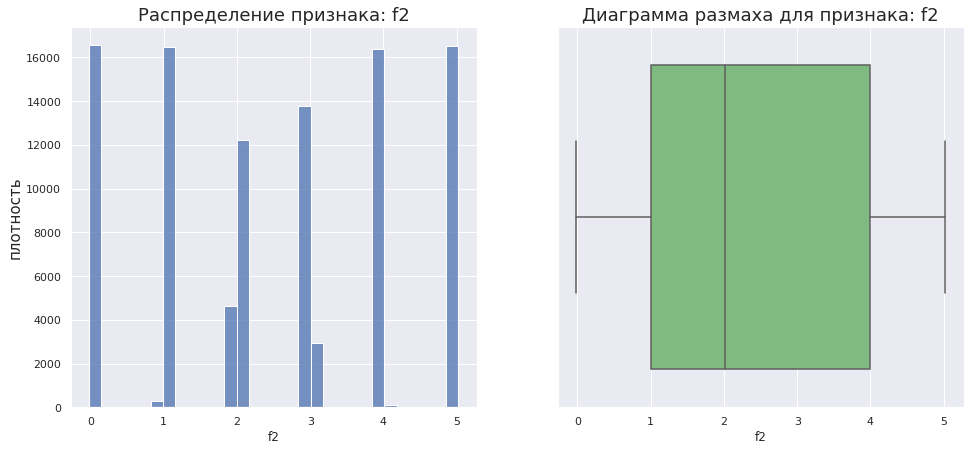

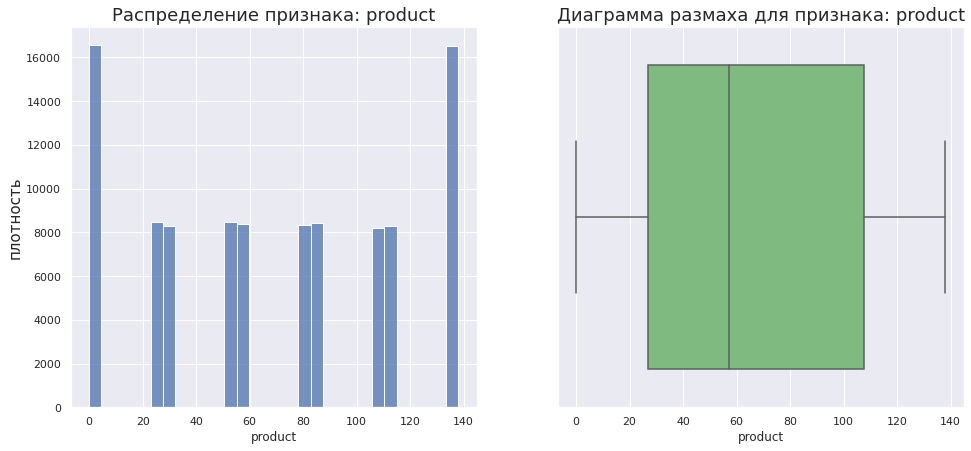

In [17]:
for column in num_features:
    plot_hist(data_1[column], column, 30);

**Признак `id` не нужен для исследования, построения модели и ее отладки.**

Удалим данный столбец из таблиц.

In [18]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

**Построим и визуализируем матрицу корреляции признаков чтобы оценить степень скоррелированности признаков.**

In [19]:
phik_overview = data_0.phik_matrix()
phik_overview.round(2);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


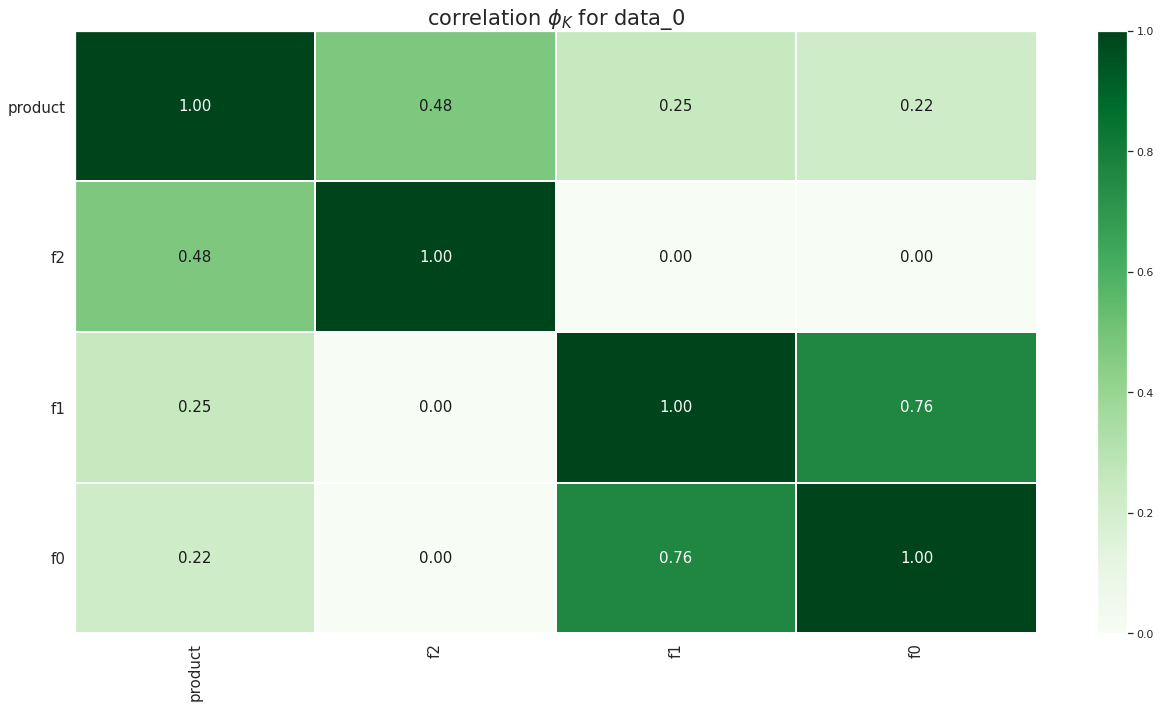

In [20]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$ for data_0", 
                        fontsize_factor=1.5, 
                        figsize=(18, 10))
plt.tight_layout()

In [21]:
phik_overview = data_1.phik_matrix()
phik_overview.round(2);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


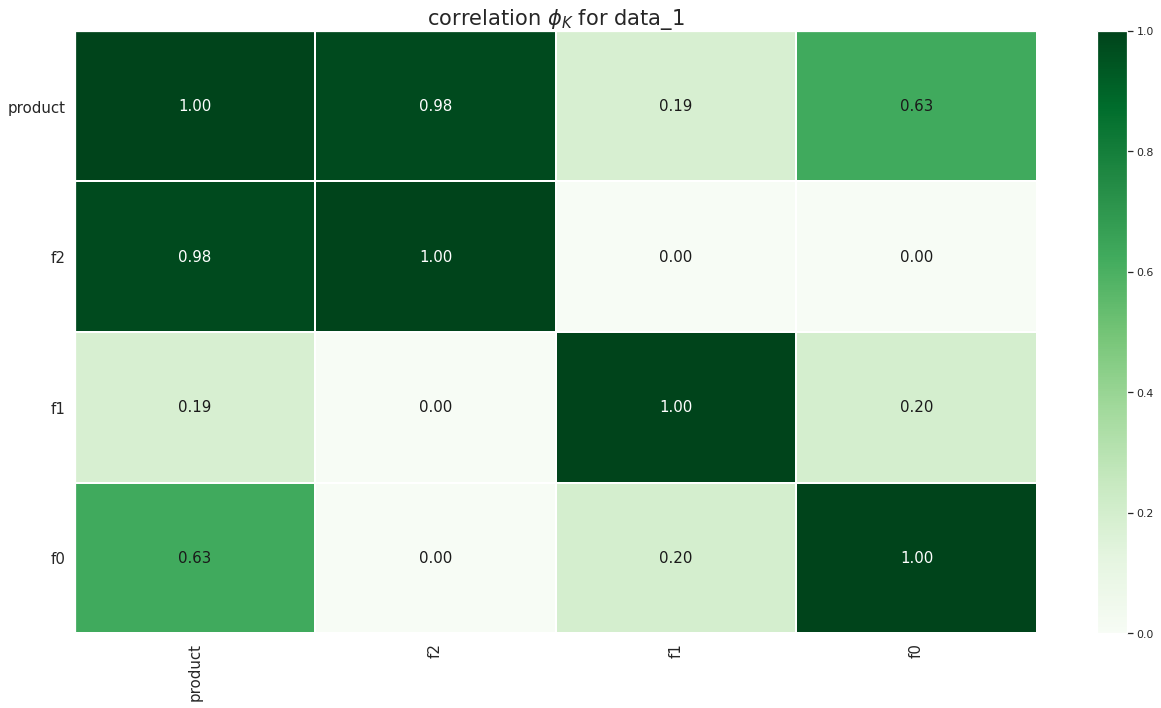

In [22]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$ for data_1", 
                        fontsize_factor=1.5, 
                        figsize=(18, 10))
plt.tight_layout()

In [23]:
phik_overview = data_2.phik_matrix()
phik_overview.round(2);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


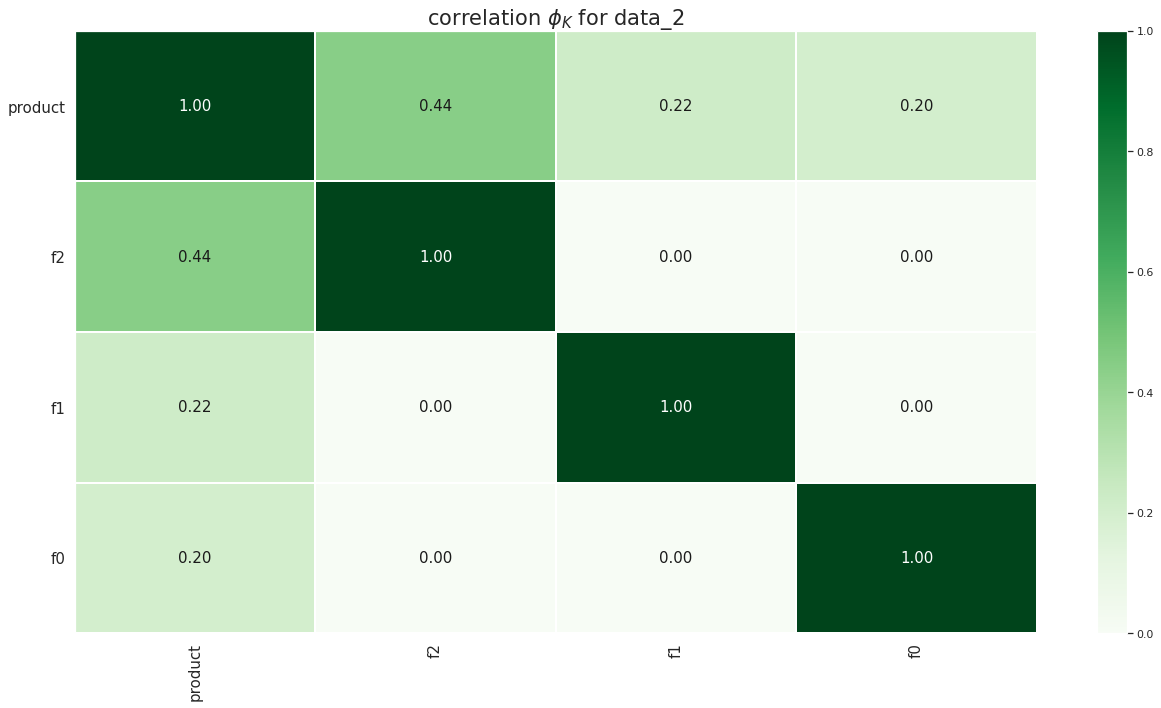

In [24]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$ for data_2", 
                        fontsize_factor=1.5, 
                        figsize=(18, 10))
plt.tight_layout()

По матрице корреляции видим, что в датасете `data_1` очень высокая корреляция между целевым признаком `product` и признаком **`f2`**.

Также средняя корреляция наблюдается между целевым признаком и `f0` в датасете `data_1`.

В  датасете `data_0` также есть средняя корреляция между признаками `f0` и `f1`.

Проверим датасет `data_1` после удаления признака `f2`

In [25]:
data_1.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


**Вывод:**
1. Импортировали необходимые библиотеки.
2. Считали данные из csv-файла.
3. Изучили и вывели общую информацию по исходным датафреймам `data_0`, `data_1`, `data_2`: 
    - в датафрейме 5 столбцов и 100000 строк;
    - все столбцы названы корректно (в змеином регистре);
    - пропуски в столбцах отсутствуют;
    - тип объектов корректный;
    - общая занимаемая память для каждого датасета 3.8+ MB.
    
    
4. Дубликатов не обнаружено. Удалили дубликаты по столбцу `id`
5. Проверили наличие дубликатов.
6. Признак `id` не нужен для исследования локации и поиска прибыльных скважин добычи нефти.

[Оглавление](#intro).
<a id='task2'></a>

## Обучение и проверка модели

Разделим выборку на 2: обучающую и валидационную. Затем обучим модель и сохраним предсказания и правильные ответы на валидационной выборке.

Для начала напишем функцию обучения модели и подсчета метрики на валидационной выборке. 

In [26]:
def lin_reg(target_train, features_train, 
                   target_valid, features_valid, class_weight=None):

    # построение модели
    model_linreg = LinearRegression() 

    # обучение модели на тренировочной выборке
    model_linreg.fit(features_train, target_train) 

    # получим предсказания модели 
    predictions_linreg = model_linreg.predict(features_valid) 

    # посчитаем метрику RMSE на валидационной выборке
    mse = mean_squared_error(target_valid, predictions_linreg)
    rmse = mse**0.5
    return predictions_linreg, rmse

Затем каждую сборку поделим на выборки, масштабируем и передадим в функцию обучения модели.

In [27]:
name=['data_0', 'data_1', 'data_2']
data=[data_0, data_1, data_2]


state= RandomState(12345)

predicted_list = []
target_list = []

#разделение данных для каждого датасета на выборки
for data, name in zip(data,name):
    features = data.drop(['product'], axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                    test_size=0.25, random_state=state)
    
    #применили метод масштабирования - стандартизация данных, 
    #чтобы выровнять диапазон значений у признаков
    scaler = StandardScaler()
    scaler.fit(features_train)

    #масштабированные данные
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    #передадим подготовленные выборки на обучение в функцию lin_reg
    predicted_linreg, rmse_model = lin_reg(target_train, features_train, 
                   target_valid, features_valid, class_weight=None)
    
    predicted_list.append(predicted_linreg)
    target_list.append(target_valid)
    
    #выведим на экран значения
    print(f'Средний запас предсказанного сырья датасета {name}:', round(predicted_linreg.mean(),2),
         'тыч. баррелей')
    print(f'RMSE модели для датасета {name}:', round(rmse_model,2))
    print()

Средний запас предсказанного сырья датасета data_0: 92.6 тыч. баррелей
RMSE модели для датасета data_0: 37.93

Средний запас предсказанного сырья датасета data_1: 69.29 тыч. баррелей
RMSE модели для датасета data_1: 0.89

Средний запас предсказанного сырья датасета data_2: 95.25 тыч. баррелей
RMSE модели для датасета data_2: 40.03



**Вывод:**
1. Для первого датасета `data_0` средний запас предсказанного сырья не самый большой из 3 регионов. Но среднеквадратичная ошибка самая маленькая. 

2. Для второго датасета `data_1` средний запас предсказанного сырья самый маленький из 3 регионов. А также среднеквадратичная ошибка самая большая. 

3. Для третьего датасета `data_2` средний запас предсказанного сырья самый большой из 3 регионов. И среднеквадратичная ошибка не амая большая. 

Здесь стоит обратить внимание на размер ошибки. В двух регионах (geo_data_0 и geo_data_2) она катастрофически большая - почти 40% от среднего запаса. И только в одном регионе (geo_data_1) она минимальная. Если посмотреть корреляцию между признаками и целевой переменной, можно понять почему в одном из регионов ошибка значительно меньше:) Высокий коэффициент корреляции f2 и целевой переменной говорит о сильной прямой линейной зависимости.


Т.к. при выборе скважин опираемся на предсказания, то качество предсказания имеет огромное значение - важно определить скважины с максимальным запасом.

[Оглавление](#intro).
<a id='task3'></a>

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [28]:
print(f"Достаточный объём сырья для безубыточной разработки новой скважины равен: {round((BUDGET / BEST_POINTS) / EARNINGS, 1)} тыс. баррелей")

Достаточный объём сырья для безубыточной разработки новой скважины равен: 111.1 тыс. баррелей


Для каждого региона определим, какой процент скважин будет безубыточен:

**Регион с датасетом `data_0`**

In [29]:
x = data_0['product']
print("Безубыточных скаважин не более, чем ", round(100 - st.percentileofscore(x, 111),1), '%')

Безубыточных скаважин не более, чем  36.7 %


Средний запас предсказанного сырья датасета data_0: 92.59256778438035

**Регион с датасетом `data_1`**

In [30]:
x = data_1['product']
print("Безубыточных скаважин не более, чем ", round(100 - st.percentileofscore(x, 111),1), '%')

Безубыточных скаважин не более, чем  16.5 %


Средний запас предсказанного сырья датасета data_1: 68.85337183075126

**Регион с датасетом `data_2`**

In [31]:
x = data_2['product']
print("Безубыточных скаважин не более, чем ", round(100 - st.percentileofscore(x, 111),1), '%')

Безубыточных скаважин не более, чем  38.3 %


Средний запас предсказанного сырья датасета data_2: 95.087528122523

**Вывод:**

**Достаточный объём сырья для безубыточной разработки новой скважины равен: 111.1 тыс. баррелей**

1. Для первого датасета `data_0` средний запас предсказанного сырья 92,6 тыс. баррелей. Менее, чем 36,6% скважин в этом регионе имеют достаточный объём сырья для безубыточной разработки. 

2. Для второго датасета `data_1` средний запас предсказанного сырья 68,8 тыс. баррелей. Менее, чем 16,5% в скважин в этом регионе имеют достаточный объём сырья для безубыточной разработки. 

3. Для третьего датасета `data_2` средний запас предсказанного сырья 95,1 тыс. баррелей. Менее, чем 38,3% скважин в этом регионе имеют достаточный объём сырья для безубыточной разработки.

[Оглавление](#intro).
<a id='task4'></a>

## Расчёт прибыли и рисков 

Напишем функцию для рассчета прибыли по лучшим 200 скважинам и предсказаниям модели.

In [32]:
def profit_calc(target, predicted_value):
    # отсортировали предсказания и оставили 200 самых лучших точек для разработки
    sorted_predictions = pd.Series(predicted_value).sort_values(ascending=False)[:BEST_POINTS]
    # отсортировали значения целевого признака в соответствии с предсказаниями лучших точек
    sorted_target = (target.reset_index(drop=True)[sorted_predictions.index])
    # подсчитали прибыль
    profit = round((sorted_target.sum() * EARNINGS) - BUDGET,2)
    return profit

**Рассчитаем прибыль по лучшим 200 скважинам для каждого региона:**

In [33]:
name=['data_0', 'data_1', 'data_2']
i = [0,1,2]
for name,i in zip(name,i):
    print(f'Прибыль по лучшим 200 скважинам для региона с датасетом {name}:', 
                                  profit_calc(target_list[i], predicted_list[i]))

Прибыль по лучшим 200 скважинам для региона с датасетом data_0: 2990084535.21
Прибыль по лучшим 200 скважинам для региона с датасетом data_1: 2415086696.68
Прибыль по лучшим 200 скважинам для региона с датасетом data_2: 2631071103.41


**Посчитаем риски и прибыль для каждого региона**

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

А также найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (Убыток — это отрицательная прибыль). 

In [34]:
def bootstrap_unit(target, predicted_value):
    # создали список для сохранения расчетов прибыли
    values = []
    # создаем 1000 случайных выборок
    for i in range(1000):
        # выбираем случайным образом из модели "n" случайных точек
        # причем точки могут повторяться
        target_subsample = pd.Series(predicted_value).sample(n=POINTS, replace=True, 
                                                                     random_state=state)
        # передаем реальные значения и предсказанную выборку из "n" случайных точек 
        # на расчет прибыли из 200 лучших точек
        values.append(profit_calc(target, target_subsample))
        
    values = pd.Series(values)
    # подсчет границ 95%-го квантиля и среднего значения
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    
    print('Риск убытков', round(st.percentileofscore(values, 0),1),"%")
    print('Средняя выручка', round(mean,2))
    print(f'95%-й доверительный интервал [{round(lower,2)}, {round(upper,2)}]')

`replace = True`, это необходимо чтобы наблюдение в выборку попало несколько раз, что позволяет добиться независимости при каждом выборе, иначе вероятность достать элемент из выборки будет с каждым разом увеличиваться. Чем больше размер подвыборки, тем выраженнее будет зависимость, поэтому без возврата не удастся получить разнообразные варианты, а подвыборку бОльшего размера вообще не получить.

In [35]:
print(f'Характеристики по лучшим 200 скважинам для региона с датасетом data_0:')
print(bootstrap_unit(target_list[0], predicted_list[0]))

print(f'\nХарактеристики по лучшим 200 скважинам для региона с датасетом data_1:')
print(bootstrap_unit(target_list[1], predicted_list[1]))  

print(f'\nХарактеристики по лучшим 200 скважинам для региона с датасетом data_2:')
print(bootstrap_unit(target_list[2], predicted_list[2])) 

Характеристики по лучшим 200 скважинам для региона с датасетом data_0:
Риск убытков 6.2 %
Средняя выручка 409781974.52
95%-й доверительный интервал [-82112635.87, 927330462.43]
None

Характеристики по лучшим 200 скважинам для региона с датасетом data_1:
Риск убытков 1.0 %
Средняя выручка 474107190.94
95%-й доверительный интервал [78159660.46, 854502212.93]
None

Характеристики по лучшим 200 скважинам для региона с датасетом data_2:
Риск убытков 10.3 %
Средняя выручка 338547067.44
95%-й доверительный интервал [-162337620.7, 853785471.83]
None


`quantile(0.025)` находит такое значение прибыли,  меньше которого только 2,5% элементов. И если это значение прибыли положительное, значит и риск меньше 2,5%. <br>
Выбирая наугад 1000 раз 500 случайных скважин и отбирая из них 200 лучших, убыток получаем менее, чем в 2,5% случаев.  

**Вывод:**

1. Для первого датасета `data_0` средняя выручка 409 781 974 руб. Риск убытков в данном регионе 6.2 %. 

2. Для второго датасета `data_1` средняя выручка 474 107 190 руб. Риск убытков в данном регионе 1 %.  

3. Для третьего датасета `data_2` средняя выручка 338 547 067 руб. Риск убытков в данном регионе 10.3 %. 

[Оглавление](#intro).
<a id='task5'></a>

## Общий вывод

1. Загрузили и подготовили данные:

2. Обучили и проверили модели:
    - Для первого датасета `data_0` средний запас предсказанного сырья не самый большой из 3 регионов. Но среднеквадратичная ошибка самая маленькая. 
    - Для второго датасета `data_1` средний запас предсказанного сырья самый маленький из 3 регионов. А также среднеквадратичная ошибка самая большая. 
    - Для третьего датасета `data_2` средний запас предсказанного сырья самый большой из 3 регионов. И среднеквадратичная ошибка не самая большая. 
    
Датасеты `data_0` и `data_2` выглядят более привлекательными по метрике "среднеквадратичная ошибка".

3. Подготовка к расчёту прибыли.

**Достаточный объём сырья для безубыточной разработки новой скважины равен: 111.1 тыс. баррелей**

    - Для первого датасета `data_0` средний запас предсказанного сырья 92,6 тыс. баррелей. Менее, чем 36,6% скважин в этом регионе имеют достаточный объём сырья для безубыточной разработки. 

    - Для второго датасета `data_1` средний запас предсказанного сырья 68,8 тыс. баррелей. Менее, чем 16,5% в скважин в этом регионе имеют достаточный объём сырья для безубыточной разработки. 

    - Для третьего датасета `data_2` средний запас предсказанного сырья 95,1 тыс. баррелей. Менее, чем 38,3% скважин в этом регионе имеют достаточный объём сырья для безубыточной разработки.

4. Расчёт прибыли и рисков .
    - Для первого датасета `data_0` средняя выручка 409 781 974 руб. Риск убытков в данном регионе 6.2 %. 

    - Для второго датасета `data_1` средняя выручка 474 107 190 руб. Риск убытков в данном регионе 1 %.  

    - Для третьего датасета `data_2` средняя выручка 338 547 067 руб. Риск убытков в данном регионе 10.3 %. 
    
Регион с датасетом `data_2` - самый убыточный. 

Из оставшихся двух регионов - только один из них удовлетворил условиям задачи "После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%."
Наиболее привлекательный - регион с датасетом `data_1`, который имеет Наименьший риск убытков равный 1%,  а также наибольшую среднюю прибыль. 

[Оглавление](#intro).
<a id='task6'></a>